<a href="https://colab.research.google.com/github/AlessLG/practicas_curvas-de-rotacion/blob/main/ajustes_curvas_rotacion_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# G = 4.3e-3 # pc • (km/s)² / M_⊙
G = 4.3e-6 # kpc • (km/s)² / M_⊙

descargar_figuras = False

def v_Hernquist(r, M, a):
    return np.sqrt(G*M*r/(a+r)**2)

def v_plummer(r, M, a):
    return np.sqrt(G*M/(r*(1+a**2/r**2)**(3/2)))

def v_nfw(r, A, r_s):
    return np.sqrt((4*np.pi*G*A)*((1/r)*np.log(1+r/r_s)-1/(r_s+r)))

def v_sol_reparam(r, rho_c, a):
    B = rho_c * (a**16)
    return v_sol(r, B, a)

def v_sol(r, B, a):
    poly_part = (
        -0.177069 * a**13 * r
        + 0.225911 * a**11 * r**3
        + 0.039069 * a**9 * r**5
        + 0.0039039 * a**7 * r**7
        + 0.000229089 * a**5 * r**9
        + 7.36645e-6 * a**3 * r**11
        + 1.00552e-7 * a * r**13
    )
    arctan_poly_part = (
        0.586978 * a**14
        + 0.373905 * a**12 * r**2
        + 0.102076 * a**10 * r**4
        + 0.0154815 * a**8 * r**6
        + 0.00140882 * a**6 * r**8
        + 7.69216e-5 * a**4 * r**10
        + 2.33329e-6 * a**2 * r**12
        + 3.03327e-8 * r**14
    )
    arctan_term = arctan_poly_part * np.arctan(0.301662 * r / a)
    numerator_content = B * G * (poly_part + arctan_term)
    denominator = a**13 * r * (a**2 + 0.091 * r**2)**7
    term_inside_sqrt = np.maximum(0, (4 * np.pi * numerator_content) / denominator)
    velocity = np.sqrt(term_inside_sqrt)
    return velocity

def v_disk_miyamoto(r, M_d, a_d, b_d):
    # (R^2 + (a+b)^2)^(3/2)
    denom = (r**2 + (a_d + b_d)**2)**(1.5)
    v_sq = (G * M_d * r**2) / denom
    return np.sqrt(v_sq)

def v_total_model(r, params, halo_func):
    # params espera: [p1_halo, p2_halo, M_disk, a_disk, b_disk]
    p_halo = params[0:2]      # Primeros 2 son del halo
    p_disk = params[2:]       # Los siguientes 3 son del disco (M, a, b)
    v_h = halo_func(r, *p_halo)
    v_d = v_disk_miyamoto(r, *p_disk)
    return np.sqrt(v_h**2 + v_d**2)

In [10]:
def fit_and_plot_rotation_curve(file_path, show_plot=True, save_plot_path=None):
    """
    Carga datos, ajusta modelos, imprime resultados y genera gráficos de ajuste
    con bandas de confianza y residuos.
    """
    data = np.genfromtxt(file_path, delimiter='\t')
    r_data, v_data, err_data = data[:, 0], data[:, 1], data[:, 2]

    model_config = {
        # "Hernquist": {"func": v_Hernquist, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        # "Plummer":   {"func": v_plummer, "x0": [1e11, 10.0], "param_labels": ["Masa", "a"]},
        "NFW":       {"func": v_nfw, "x0": [1e11, 10.0], "param_labels": ["A", "r_s"]},
        # "Solitón":   {"func": v_sol_reparam, "x0": [1e7, 10.0], "param_labels": ["ρ_c", "a"]},
    }
    
    resultados = {}

    def residuals(params, func, r, v_obs, v_err):
        return (func(r, *params) - v_obs) / v_err

    for name, config in model_config.items():
        res = least_squares(residuals, config["x0"], args=(config["func"], r_data, v_data, err_data), bounds=([0, 0], [np.inf, np.inf]))
        params, J = res.x, res.jac
        
        cov_matrix = None # Inicializamos la matriz de covarianza
        try:
            cov_matrix = np.linalg.inv(J.T @ J)
            errors = np.sqrt(np.diag(cov_matrix))
        except np.linalg.LinAlgError:
            errors = [np.inf, np.inf]
        
        dof = len(v_data) - len(params)
        chi2_red = np.sum(res.fun**2) / dof if dof > 0 else np.inf
        
        # Guardamos también la matriz de covarianza
        resultados[name] = {"params": params, "errors": errors, "chi2_red": chi2_red, "cov_matrix": cov_matrix}

    # --- Impresión de Resultados ---
    galaxy_name = os.path.basename(file_path).split('_')[0]
    print(f"\n--- Resultados de Ajustes para la Galaxia: {galaxy_name} ---")
    # ... (El código de impresión no necesita cambios)
    for name, res in sorted(resultados.items(), key=lambda item: item[1]['chi2_red']):
        p1, p2 = res['params']
        e1, e2 = res['errors']
        l1, l2 = model_config[name]["param_labels"]
        unit = "M⊙/kpc³" if name == "Solitón" else "M⊙"
        print(f"{name}: (χ²_red = {res['chi2_red']:.3f})")
        print(f"  {l1:<5} = ({p1:.2e} ± {e1:.1e}) {unit}")
        print(f"  {l2:<5} = ({p2:.2f} ± {e2:.2f}) kpc")
        print("-" * 45)


    # --- 4. Generación del Gráfico de Ajuste con Banda de Confianza ---
    if not (show_plot or save_plot_path):
        return resultados

    d = np.linspace(0.1, r_data.max(), 200)
    plt.figure(figsize=(6, 4))
    
    # --- Bucle para graficar cada modelo ajustado (ahora solo será uno) ---
    for name, res in resultados.items():
        if res["cov_matrix"] is None:
            print(f"No se pudo calcular la banda de confianza para {name} (matriz singular).")
            continue

        model_func = model_config[name]["func"]
        p_fit = res["params"]
        cov = res["cov_matrix"]
        
        # Curva de mejor ajuste
        v_fit = model_func(d, *p_fit)
        plt.plot(d, v_fit, 'r-', label=f'Ajuste {name} (χ²_red={res["chi2_red"]:.2f})')
        
        # --- Cálculo de la Banda de Confianza (1-sigma) ---
        sigma_v = np.zeros_like(d)
        p1, p2 = p_fit
        
        for i, r_val in enumerate(d):
            # Derivadas numéricas del modelo en cada punto r
            h1 = p1 * 1e-4 # Pequeño paso para el parámetro 1
            h2 = p2 * 1e-4 # Pequeño paso para el parámetro 2
            
            dv_dp1 = (model_func(r_val, p1 + h1, p2) - model_func(r_val, p1 - h1, p2)) / (2 * h1)
            dv_dp2 = (model_func(r_val, p1, p2 + h2) - model_func(r_val, p1, p2 - h2)) / (2 * h2)
            
            J_model = np.array([dv_dp1, dv_dp2])
            
            # Propagación de errores: sigma_v^2 = J^T * C * J
            variance_v = J_model.T @ cov @ J_model
            sigma_v[i] = np.sqrt(variance_v)
            
        # Dibujar la banda de confianza
        plt.fill_between(d, v_fit - sigma_v, v_fit + sigma_v, color='red', alpha=0.3, label='Banda de confianza (1σ)')
        
    # Graficar datos observacionales
    plt.errorbar(r_data, v_data, yerr=err_data, fmt='o', color='black', label='Datos SPARC', capsize=4, markersize=5)

    plt.xlabel('Radio (kpc)')
    plt.ylabel('Velocidad (km/s)')
    plt.title(f'Ajuste de Curva de Rotación para {galaxy_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if save_plot_path:
        plt.savefig(f"{galaxy_name}_fit_confidence.png", bbox_inches='tight')
        
    if show_plot:
        plt.show()
    plt.close()
    
    return resultados


--- Resultados de Ajustes para la Galaxia: F563-1 ---
NFW: (χ²_red = 1.068)
  A     = (2.22e+10 ± 9.4e+09) M⊙
  r_s   = (18.21 ± 5.16) kpc
---------------------------------------------


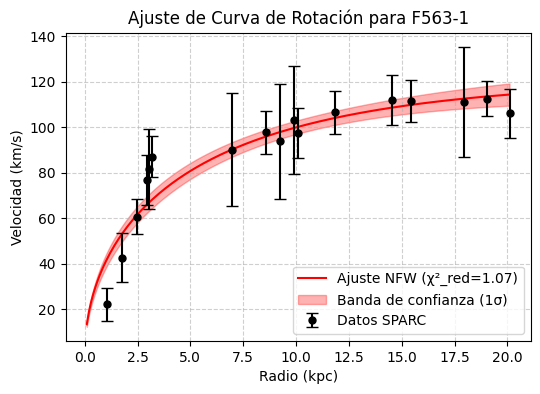


--- Resultados de Ajustes para la Galaxia: F563-V2 ---
NFW: (χ²_red = 1.359)
  A     = (8.58e+10 ± 1.4e+11) M⊙
  r_s   = (30.28 ± 27.27) kpc
---------------------------------------------


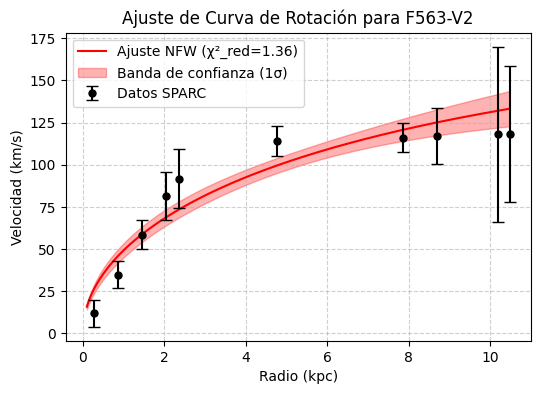


--- Resultados de Ajustes para la Galaxia: F568-1 ---
NFW: (χ²_red = 0.797)
  A     = (1.70e+11 ± 2.6e+11) M⊙
  r_s   = (43.33 ± 36.28) kpc
---------------------------------------------


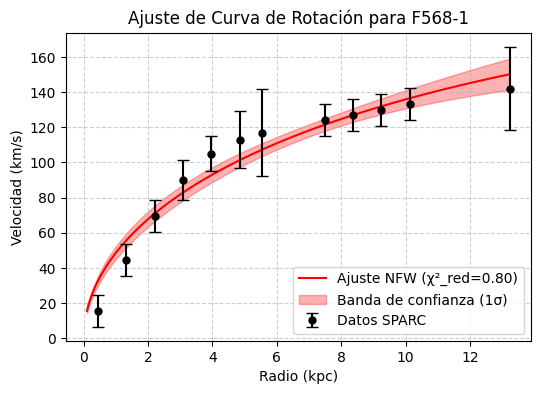


--- Resultados de Ajustes para la Galaxia: F568-3 ---
NFW: (χ²_red = 3.484)
  A     = (3.34e+13 ± 3.2e+14) M⊙
  r_s   = (991.00 ± 4812.15) kpc
---------------------------------------------


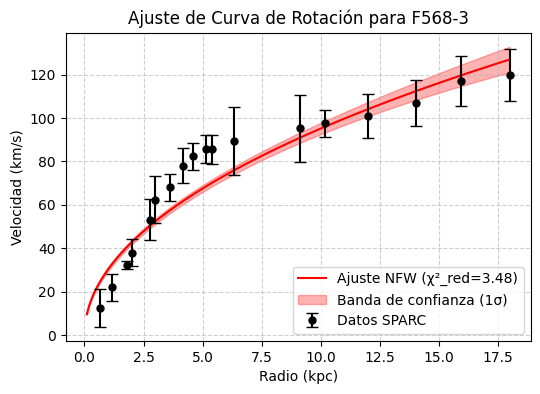


--- Resultados de Ajustes para la Galaxia: F568-V1 ---
NFW: (χ²_red = 0.201)
  A     = (1.08e+10 ± 4.8e+09) M⊙
  r_s   = (8.49 ± 2.57) kpc
---------------------------------------------


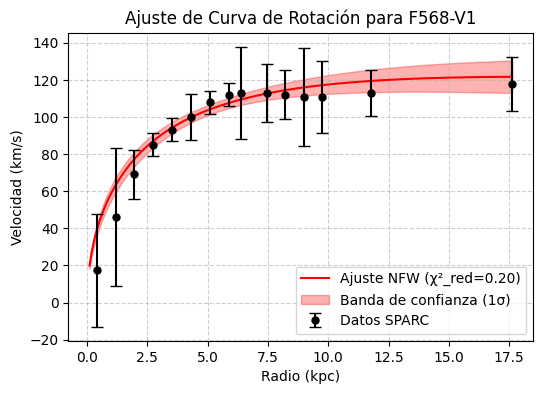


--- Resultados de Ajustes para la Galaxia: F571-8 ---
NFW: (χ²_red = 1.459)
  A     = (9.27e+10 ± 3.4e+10) M⊙
  r_s   = (30.81 ± 6.57) kpc
---------------------------------------------


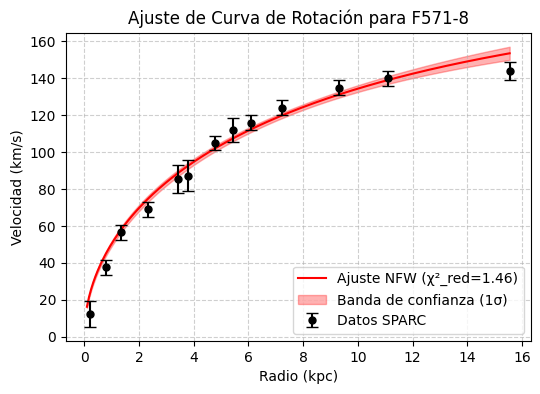


--- Resultados de Ajustes para la Galaxia: F574-1 ---
NFW: (χ²_red = 1.601)
  A     = (1.76e+10 ± 5.7e+09) M⊙
  r_s   = (15.84 ± 3.29) kpc
---------------------------------------------


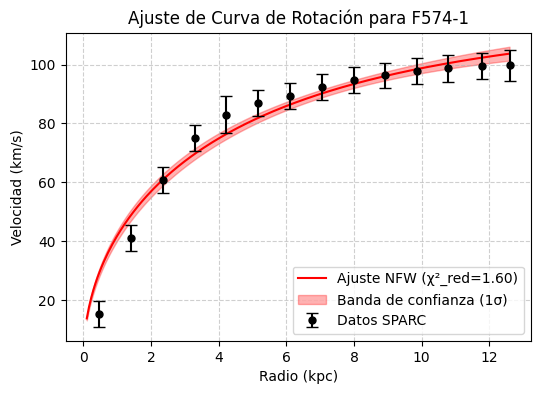


--- Resultados de Ajustes para la Galaxia: F579-V1 ---
NFW: (χ²_red = 0.206)
  A     = (5.73e+09 ± 1.6e+09) M⊙
  r_s   = (5.18 ± 1.13) kpc
---------------------------------------------


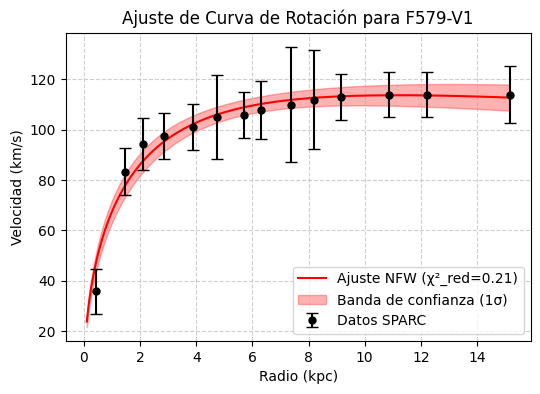


--- Resultados de Ajustes para la Galaxia: F583-1 ---
NFW: (χ²_red = 1.451)
  A     = (4.90e+10 ± 3.1e+10) M⊙
  r_s   = (37.73 ± 13.03) kpc
---------------------------------------------


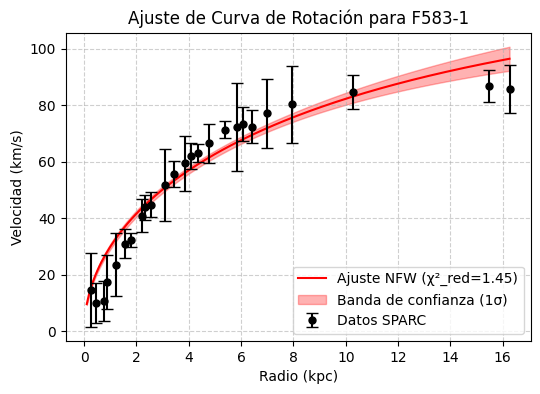


--- Resultados de Ajustes para la Galaxia: F583-4 ---
NFW: (χ²_red = 0.228)
  A     = (1.33e+10 ± 1.5e+10) M⊙
  r_s   = (18.86 ± 12.61) kpc
---------------------------------------------


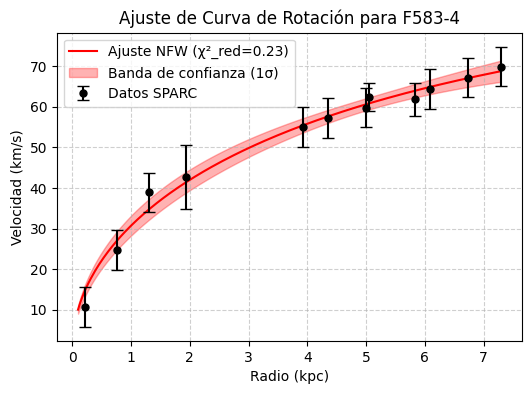


--- Resultados de Ajustes para la Galaxia: UGC05750 ---
NFW: (χ²_red = 1.302)
  A     = (8.76e+10 ± 1.6e+11) M⊙
  r_s   = (66.11 ± 63.07) kpc
---------------------------------------------


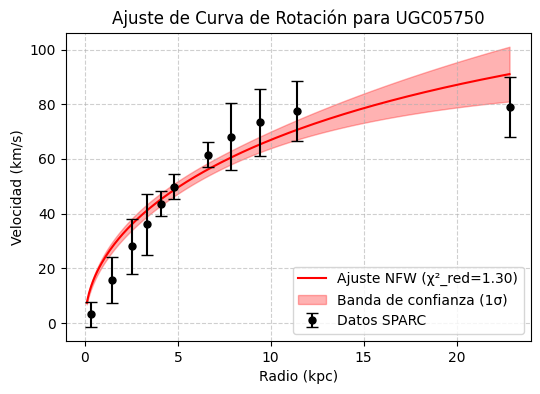


--- Resultados de Ajustes para la Galaxia: UGC06614 ---
NFW: (χ²_red = 2.278)
  A     = (5.50e+10 ± 1.0e+10) M⊙
  r_s   = (16.38 ± 2.35) kpc
---------------------------------------------


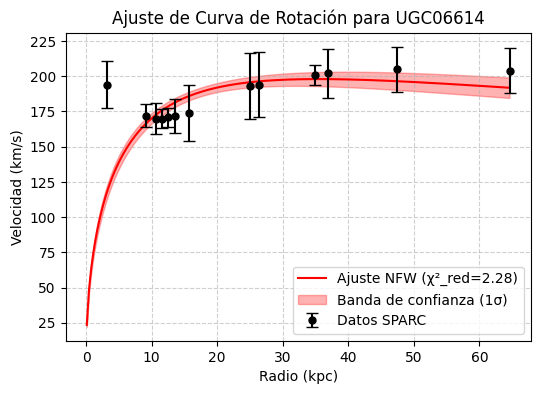

In [11]:
# Lista de archivos de galaxias que quieres analizar
galaxy_files = [
    'data_lsb/F563-1_rotmod.dat',
    'data_lsb/F563-V2_rotmod.dat',
    'data_lsb/F568-1_rotmod.dat',
    'data_lsb/F568-3_rotmod.dat',
    'data_lsb/F568-V1_rotmod.dat',
    'data_lsb/F571-8_rotmod.dat',
    'data_lsb/F574-1_rotmod.dat',
    'data_lsb/F579-V1_rotmod.dat',
    'data_lsb/F583-1_rotmod.dat',
    'data_lsb/F583-4_rotmod.dat',
    'data_lsb/UGC05750_rotmod.dat',
    'data_lsb/UGC06614_rotmod.dat'
]

# Un diccionario para guardar todos los resultados si los necesitas después
resultados = {}

# Itera sobre cada archivo, realiza el análisis completo y muestra los resultados
for file in galaxy_files:
    galaxy_name = os.path.basename(file).split('_')[0]
    results = fit_and_plot_rotation_curve(
        file_path=file,
        show_plot=True,
        save_plot_path=False
        # save_plot_path=f"{galaxy_name}_fit.pdf"
    )

    if results:
        resultados[galaxy_name] = results